In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Necessary Dependencies
import numpy as np
import pandas as pd
!pip install utils
from utils import *
from glob import glob
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from itertools import chain
from datetime import datetime
import statistics
from tqdm import tqdm
import tensorflow as tf
# DenseNet Dependencies
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.layers import Dense,Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC, BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201, VGG16, ResNet50
from keras import backend as K
from tensorflow.keras import Sequential
import keras
import matplotlib
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from sklearn.metrics import roc_curve, auc
print('Started')

Started


In [ ]:
cd /content/drive/MyDrive/Machine learning 2024/Notebooks - ANN - DNN/7.Stroke Classification with transfer learning

/content/drive/MyDrive/Machine learning 2024/Notebooks - ANN - DNN/7.Stroke Classification with transfer learning


In [ ]:
path, dirs, files = next(os.walk("Brain_Data_Organised/Train/Stroke"))
file_count = len(files)
print('Stroke:',file_count)
path, dirs, files = next(os.walk("Brain_Data_Organised/Train/Normal"))
file_count = len(files)
print('Non-Stroke:',file_count)

Stroke: 950
Non-Stroke: 1426


In [ ]:
image_size = (224, 224)
batch_size = 32

train_df = tf.keras.preprocessing.image_dataset_from_directory(
    "Brain_Data_Organised/Train",
    validation_split=0.20,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_df = tf.keras.preprocessing.image_dataset_from_directory(
    "Brain_Data_Organised/Train",
    validation_split=0.20,
    subset="validation",
    seed=333,
    image_size=image_size,
    batch_size=batch_size,
)
test_df = tf.keras.preprocessing.image_dataset_from_directory(
    "Brain_Data_Organised/Test",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False,   # very impportant
)

Found 2376 files belonging to 2 classes.
Using 1901 files for training.
Found 2376 files belonging to 2 classes.
Using 475 files for validation.
Found 250 files belonging to 2 classes.


In [ ]:
y_true = np.concatenate([y for x, y in test_df], axis=0)

In [ ]:
train_df = train_df.prefetch(buffer_size=32)
val_df = val_df.prefetch(buffer_size=32)

In [ ]:
# Hyperparameters
IMG_IND=224
IMG_SHAPE = (IMG_IND,IMG_IND,3)
LOSS = BinaryCrossentropy() # Not un-weighted
SEED = 2
BATCH_SIZE = 16

In [ ]:
def get_callbacks(model_name):
    callbacks =[]

    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_loss',mode='min',save_best_only=True)
    callbacks.append(checkpoint)
    anne = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=2, min_lr=0.0000001,min_delta=0.00001,mode='auto')
    callbacks.append(anne)
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    callbacks.append(earlystop)

    return callbacks

## Dense Net Model

In [ ]:
OPTIMIZER =Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

base_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
base_model.trainable = True

x = base_model.output     # last layer

x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid',name='Final')(x)
model = Model(inputs=base_model.input, outputs=predictions)
#model.load_weights(dire)
model.compile(loss ='binary_crossentropy',optimizer=OPTIMIZER,metrics=['accuracy',keras.metrics.Precision(),
                                                                       keras.metrics.Recall(), keras.metrics.SpecificityAtSensitivity(0.5),
                                                                       keras.metrics.SensitivityAtSpecificity(0.5)])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Need to know the number of layers

print(len(model.layers))


429


In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
callbacks = get_callbacks('dense121')
history = model.fit( train_df,epochs=50,
                    validation_data= val_df,
                    callbacks=[callbacks])

Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 0.5412 - accuracy: 0.7359 - precision: 0.6831 - recall: 0.6233 - specificity_at_sensitivity: 0.8893 - sensitivity_at_specificity: 0.8767
Epoch 1: val_loss improved from inf to 12.33481, saving model to model.dense121.h5
60/60 [==============================] - 611s 9s/step - loss: 0.5412 - accuracy: 0.7359 - precision: 0.6831 - recall: 0.6233 - specificity_at_sensitivity: 0.8893 - sensitivity_at_specificity: 0.8767 - val_loss: 12.3348 - val_accuracy: 0.5789 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_specificity_at_sensitivity: 0.0000e+00 - val_sensitivity_at_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/50
60/60 [==============================] - ETA: 0s - loss: 0.3143 - accuracy: 0.8716 - precision: 0.8571 - recall: 0.8117 - specificity_at_sensitivity: 0.9826 - sensitivity_at_specificity: 0.9788
Epoch 2: val_loss improved from 12.33481 to 3.59073, saving model to model.dense121.h5
60/60 [===============

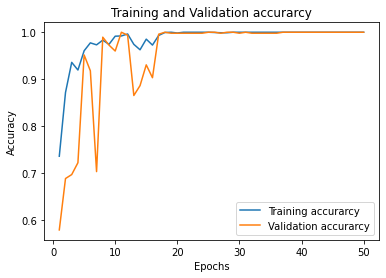

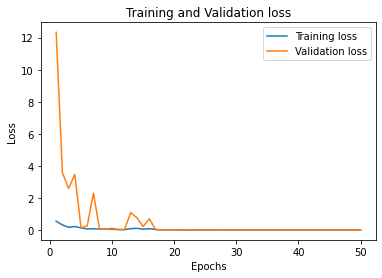

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, label='Training accurarcy')
plt.plot(epochs, val_acc, label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model('model.dense121.h5')

In [ ]:
results = model.evaluate(test_df, verbose=1)

8/8 [==============================] - 5s 329ms/step - loss: 0.0611 - accuracy: 0.9840 - precision: 0.9764 - recall: 0.9920 - specificity_at_sensitivity: 1.0000 - sensitivity_at_specificity: 0.9920


In [ ]:
y_pred = model.predict(test_df, verbose=1).round()   #  because we use sigmoid  >= 0.5 ? 1 , 0
y_pred = y_pred.flatten()

8/8 [==============================] - 3s 118ms/step
                  precision    recall  f1-score   support

class non stroke     0.9919    0.9760    0.9839       125
    class stroke     0.9764    0.9920    0.9841       125

        accuracy                         0.9840       250
       macro avg     0.9841    0.9840    0.9840       250
    weighted avg     0.9841    0.9840    0.9840       250



              precision    recall  f1-score   support

      Stroke     0.9919    0.9760    0.9839       125
  Non stroke     0.9764    0.9920    0.9841       125

    accuracy                         0.9840       250
   macro avg     0.9841    0.9840    0.9840       250
weighted avg     0.9841    0.9840    0.9840       250



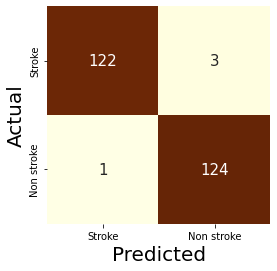

In [ ]:
from sklearn.metrics import confusion_matrix
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd

target_names= ['Normal', 'Stroke']

report=classification_report(y_true, y_pred, target_names=target_names, digits=4)
print(report)


disp = confusion_matrix(y_true, y_pred)
disp.astype('int')
pd.options.display.float_format = '{:.5f}'.format
df_cm = pd.DataFrame(disp, target_names, target_names)
# plt.figure(figsize=(10,7))
fig, ax = plt.subplots(figsize=(4,4))
sn.set(font_scale=1.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15},ax=ax, cmap="YlOrBr" , fmt='g',cbar=False) # font size
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.ioff()
plt.savefig("confusion_mat", bbox_inches='tight')
plt.show()


## RESNet 50

In [ ]:
OPTIMIZER =Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')

base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid',name='Final')(x)
model = Model(inputs=base_model.input, outputs=predictions)
#model.load_weights(dire)
model.compile(loss ='binary_crossentropy',optimizer=OPTIMIZER,metrics=['accuracy',keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.SpecificityAtSensitivity(0.5), keras.metrics.SensitivityAtSpecificity(0.5)])

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
callbacks = get_callbacks('resnet50')
history = model.fit( train_df,epochs=50,
                    validation_data= val_df,
                    callbacks=[callbacks])

Epoch 1/50
64/64 [==============================] - ETA: 0s - loss: 0.6447 - accuracy: 0.7124 - precision: 0.6610 - recall: 0.5767 - specificity_at_sensitivity: 0.8639 - sensitivity_at_specificity: 0.8379
Epoch 1: val_loss improved from inf to 54.90076, saving model to model.resnet50.h5
64/64 [==============================] - 593s 8s/step - loss: 0.6447 - accuracy: 0.7124 - precision: 0.6610 - recall: 0.5767 - specificity_at_sensitivity: 0.8639 - sensitivity_at_specificity: 0.8379 - val_loss: 54.9008 - val_accuracy: 0.5758 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_specificity_at_sensitivity: 0.0000e+00 - val_sensitivity_at_specificity: 0.0662 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - ETA: 0s - loss: 0.2825 - accuracy: 0.8876 - precision: 0.8645 - recall: 0.8527 - specificity_at_sensitivity: 0.9818 - sensitivity_at_specificity: 0.9901
Epoch 2: val_loss improved from 54.90076 to 1.85745, saving model to model.resnet50.h5
64/64 [===================

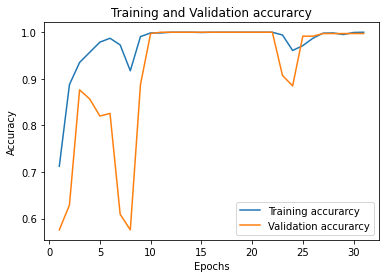

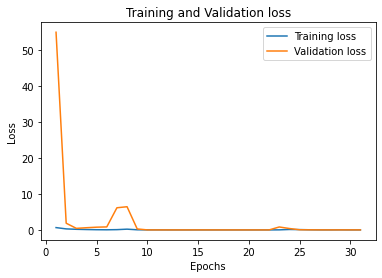

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, label='Training accurarcy')
plt.plot(epochs, val_acc, label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model('model.resnet50.keras')

In [ ]:
results = model.evaluate(test_df, steps=len(test_df), verbose=1)

8/8 [==============================] - 2s 211ms/step - loss: 0.1050 - accuracy: 0.9680 - precision: 0.9398 - recall: 1.0000 - specificity_at_sensitivity: 0.9840 - sensitivity_at_specificity: 1.0000


In [ ]:
y_pred = model.predict(test_df, verbose=1).round()
y_pred = y_pred.flatten()
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

8/8 [==============================] - 2s 129ms/step
              precision    recall  f1-score   support

     class 0     1.0000    0.9360    0.9669       125
     class 1     0.9398    1.0000    0.9690       125

    accuracy                         0.9680       250
   macro avg     0.9699    0.9680    0.9680       250
weighted avg     0.9699    0.9680    0.9680       250



              precision    recall  f1-score   support

      Stroke     1.0000    0.9360    0.9669       125
  Non stroke     0.9398    1.0000    0.9690       125

    accuracy                         0.9680       250
   macro avg     0.9699    0.9680    0.9680       250
weighted avg     0.9699    0.9680    0.9680       250



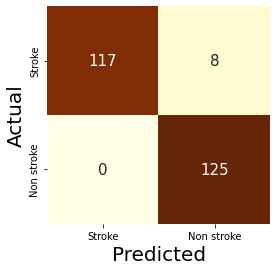

In [ ]:
from sklearn.metrics import confusion_matrix
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd

report=classification_report(y_true, y_pred, target_names=target_names, digits=4)
print(report)


disp = confusion_matrix(y_true, y_pred)
disp.astype('int')
pd.options.display.float_format = '{:.5f}'.format
df_cm = pd.DataFrame(disp, target_names, target_names)
# plt.figure(figsize=(10,7))
fig, ax = plt.subplots(figsize=(4,4))
sn.set(font_scale=1.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15},ax=ax, cmap="YlOrBr" , fmt='g',cbar=False) # font size
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.ioff()
plt.savefig("confusion_mat", bbox_inches='tight')
plt.show()


## VGG16

In [ ]:
OPTIMIZER =Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')

base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid',name='Final')(x)
model = Model(inputs=base_model.input, outputs=predictions)
#model.load_weights(dire)
model.compile(loss ='binary_crossentropy',optimizer=OPTIMIZER,metrics=['accuracy',keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.SpecificityAtSensitivity(0.5), keras.metrics.SensitivityAtSpecificity(0.5)])
#model.summary()

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
callbacks = get_callbacks('vgg16')
history = model.fit( train_df,epochs=50,
                    validation_data= val_df,
                    callbacks=[callbacks])

Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 8.1004 - accuracy: 0.5660 - precision: 0.4199 - recall: 0.2467 - specificity_at_sensitivity: 0.5048 - sensitivity_at_specificity: 0.5225
Epoch 1: val_loss improved from inf to 0.69270, saving model to model.vgg16.h5
60/60 [==============================] - 636s 9s/step - loss: 8.1004 - accuracy: 0.5660 - precision: 0.4199 - recall: 0.2467 - specificity_at_sensitivity: 0.5048 - sensitivity_at_specificity: 0.5225 - val_loss: 0.6927 - val_accuracy: 0.5789 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_specificity_at_sensitivity: 0.0000e+00 - val_sensitivity_at_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/50
60/60 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.6034 - precision: 0.0000e+00 - recall: 0.0000e+00 - specificity_at_sensitivity: 0.2049 - sensitivity_at_specificity: 0.1485
Epoch 2: val_loss improved from 0.69270 to 0.69030, saving model to model.vgg16.h5
60/60 [================

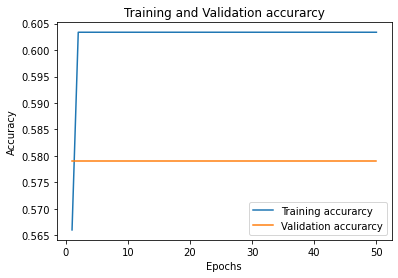

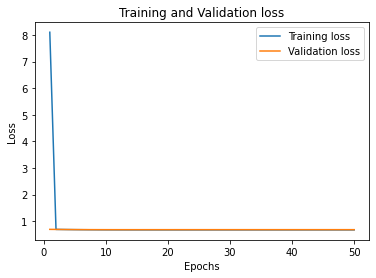

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, label='Training accurarcy')
plt.plot(epochs, val_acc, label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model('model.vgg16.keras')

In [ ]:
results = model.evaluate(test_df, steps=len(test_df), verbose=1)

8/8 [==============================] - 4s 503ms/step - loss: 0.7112 - accuracy: 0.5000 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - specificity_at_sensitivity_1: 0.0000e+00 - sensitivity_at_specificity_1: 0.0000e+00


In [ ]:
y_pred = model.predict(test_df, verbose=1).round()
y_pred = y_pred.flatten()
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

8/8 [==============================] - 1s 167ms/step
              precision    recall  f1-score   support

     class 0     0.5000    1.0000    0.6667       125
     class 1     0.0000    0.0000    0.0000       125

    accuracy                         0.5000       250
   macro avg     0.2500    0.5000    0.3333       250
weighted avg     0.2500    0.5000    0.3333       250



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      Stroke     0.5000    1.0000    0.6667       125
  Non stroke     0.0000    0.0000    0.0000       125

    accuracy                         0.5000       250
   macro avg     0.2500    0.5000    0.3333       250
weighted avg     0.2500    0.5000    0.3333       250



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


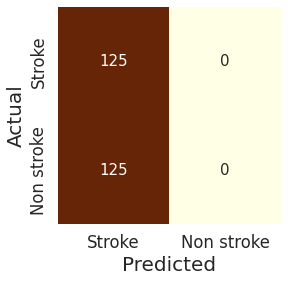

In [ ]:
from sklearn.metrics import confusion_matrix
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd

report=classification_report(y_true, y_pred, target_names=target_names, digits=4)
print(report)


disp = confusion_matrix(y_true, y_pred)
disp.astype('int')
pd.options.display.float_format = '{:.5f}'.format
df_cm = pd.DataFrame(disp, target_names, target_names)
# plt.figure(figsize=(10,7))
fig, ax = plt.subplots(figsize=(4,4))
sn.set(font_scale=1.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15},ax=ax, cmap="YlOrBr" , fmt='g',cbar=False) # font size
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.ioff()
plt.savefig("confusion_mat", bbox_inches='tight')
plt.show()


## MobileNet model

In [ ]:
OPTIMIZER =Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
base_model=tf.keras.applications.mobilenet.MobileNet(include_top=False, weights="imagenet",input_shape=IMG_SHAPE)

base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid',name='Final')(x)
model = Model(inputs=base_model.input, outputs=predictions)
#model.load_weights(dire)
model.compile(loss ='binary_crossentropy',optimizer=OPTIMIZER,metrics=['accuracy',keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.SpecificityAtSensitivity(0.5), keras.metrics.SensitivityAtSpecificity(0.5)])
#model.summary()

17225924/17225924 [==============================] - 1s 0us/step


In [ ]:
callbacks = get_callbacks('MobileNet')
history = model.fit( train_df,epochs=50,
                    validation_data= val_df,
                    callbacks=[callbacks])

Epoch 1/50
64/64 [==============================] - ETA: 0s - loss: 0.5544 - accuracy: 0.7743 - precision_2: 0.7206 - recall_2: 0.7116 - specificity_at_sensitivity_2: 0.9125 - sensitivity_at_specificity_2: 0.8973
Epoch 1: val_loss improved from inf to 4.92119, saving model to model.MobileNet.h5
64/64 [==============================] - 19s 224ms/step - loss: 0.5544 - accuracy: 0.7743 - precision_2: 0.7206 - recall_2: 0.7116 - specificity_at_sensitivity_2: 0.9125 - sensitivity_at_specificity_2: 0.8973 - val_loss: 4.9212 - val_accuracy: 0.5758 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_specificity_at_sensitivity_2: 0.0000e+00 - val_sensitivity_at_specificity_2: 0.0000e+00 - lr: 0.0010
Epoch 2/50
63/64 [============================>.] - ETA: 0s - loss: 0.2117 - accuracy: 0.9137 - precision_2: 0.8922 - recall_2: 0.8922 - specificity_at_sensitivity_2: 0.9959 - sensitivity_at_specificity_2: 0.9975
Epoch 2: val_loss improved from 4.92119 to 0.19341, saving model to model.Mo

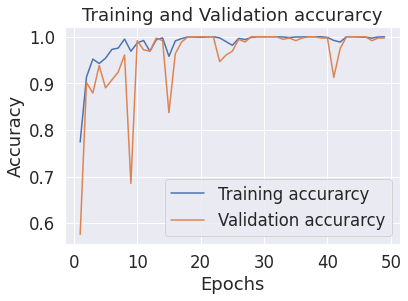

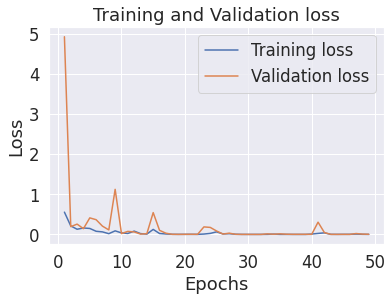

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, label='Training accurarcy')
plt.plot(epochs, val_acc, label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model('model.MobileNet.keras')

In [ ]:
results = model.evaluate(test_df, steps=len(test_df), verbose=1)

8/8 [==============================] - 1s 141ms/step - loss: 0.2731 - accuracy: 0.9600 - precision_2: 0.9259 - recall_2: 1.0000 - specificity_at_sensitivity_2: 0.9600 - sensitivity_at_specificity_2: 1.0000


In [ ]:
y_pred = model.predict(test_df, verbose=1).round()
y_pred = y_pred.flatten()
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

8/8 [==============================] - 1s 87ms/step
              precision    recall  f1-score   support

     class 0     1.0000    0.9200    0.9583       125
     class 1     0.9259    1.0000    0.9615       125

    accuracy                         0.9600       250
   macro avg     0.9630    0.9600    0.9599       250
weighted avg     0.9630    0.9600    0.9599       250



              precision    recall  f1-score   support

      Stroke     1.0000    0.9200    0.9583       125
  Non stroke     0.9259    1.0000    0.9615       125

    accuracy                         0.9600       250
   macro avg     0.9630    0.9600    0.9599       250
weighted avg     0.9630    0.9600    0.9599       250



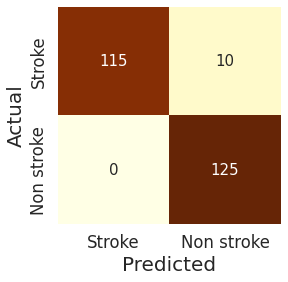

In [ ]:
from sklearn.metrics import confusion_matrix
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd

report=classification_report(y_true, y_pred, target_names=target_names, digits=4)
print(report)


disp = confusion_matrix(y_true, y_pred)
disp.astype('int')
pd.options.display.float_format = '{:.5f}'.format
df_cm = pd.DataFrame(disp, target_names, target_names)
# plt.figure(figsize=(10,7))
fig, ax = plt.subplots(figsize=(4,4))
sn.set(font_scale=1.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15},ax=ax, cmap="YlOrBr" , fmt='g',cbar=False) # font size
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.ioff()
plt.savefig("confusion_mat", bbox_inches='tight')
plt.show()


## Xception

In [ ]:
OPTIMIZER =Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
base_model=tf.keras.applications.xception.Xception(include_top=False, weights="imagenet",input_shape=IMG_SHAPE)

base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid',name='Final')(x)
model = Model(inputs=base_model.input, outputs=predictions)
#model.load_weights(dire)
model.compile(loss ='binary_crossentropy',optimizer=OPTIMIZER,metrics=['accuracy',keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.SpecificityAtSensitivity(0.5), keras.metrics.SensitivityAtSpecificity(0.5)])
#model.summary()


83683744/83683744 [==============================] - 4s 0us/step


In [ ]:
callbacks = get_callbacks('Xception')
history = model.fit( train_df,epochs=30,
                    validation_data= val_df,
                    callbacks=[callbacks])

Epoch 1/30
64/64 [==============================] - ETA: 0s - loss: 0.6023 - accuracy: 0.6441 - precision_3: 0.6083 - recall_3: 0.3094 - specificity_at_sensitivity_3: 0.7450 - sensitivity_at_specificity_3: 0.8280
Epoch 1: val_loss improved from inf to 1.03190, saving model to model.Xception.h5
64/64 [==============================] - 59s 788ms/step - loss: 0.6023 - accuracy: 0.6441 - precision_3: 0.6083 - recall_3: 0.3094 - specificity_at_sensitivity_3: 0.7450 - sensitivity_at_specificity_3: 0.8280 - val_loss: 1.0319 - val_accuracy: 0.6826 - val_precision_3: 0.6203 - val_recall_3: 0.6490 - val_specificity_at_sensitivity_3: 0.7659 - val_sensitivity_at_specificity_3: 0.9007 - lr: 0.0010
Epoch 2/30
64/64 [==============================] - ETA: 0s - loss: 0.3774 - accuracy: 0.8297 - precision_3: 0.7937 - recall_3: 0.7760 - specificity_at_sensitivity_3: 0.9497 - sensitivity_at_specificity_3: 0.9777
Epoch 2: val_loss did not improve from 1.03190
64/64 [==============================] - 41s 6

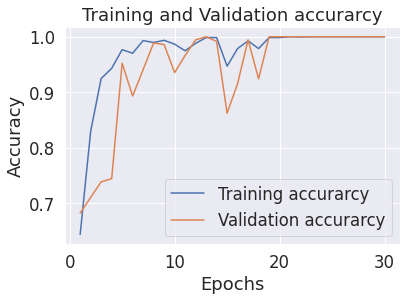

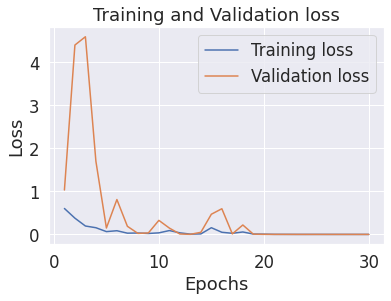

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, label='Training accurarcy')
plt.plot(epochs, val_acc, label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model('model.Xception.keras')

In [ ]:
results = model.evaluate(test_df, steps=len(test_df), verbose=1)

8/8 [==============================] - 2s 293ms/step - loss: 0.1012 - accuracy: 0.9840 - precision_3: 0.9690 - recall_3: 1.0000 - specificity_at_sensitivity_3: 0.9760 - sensitivity_at_specificity_3: 1.0000


In [ ]:
y_pred = model.predict(test_df, verbose=1).round()
y_pred = y_pred.flatten()
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

8/8 [==============================] - 2s 143ms/step
              precision    recall  f1-score   support

     class 0     1.0000    0.9680    0.9837       125
     class 1     0.9690    1.0000    0.9843       125

    accuracy                         0.9840       250
   macro avg     0.9845    0.9840    0.9840       250
weighted avg     0.9845    0.9840    0.9840       250



              precision    recall  f1-score   support

      Stroke     1.0000    0.9680    0.9837       125
  Non stroke     0.9690    1.0000    0.9843       125

    accuracy                         0.9840       250
   macro avg     0.9845    0.9840    0.9840       250
weighted avg     0.9845    0.9840    0.9840       250



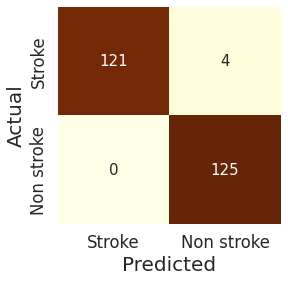

In [ ]:
from sklearn.metrics import confusion_matrix
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd

target_names = ['Stroke', 'Non stroke']


report=classification_report(y_true, y_pred, target_names=target_names, digits=4)
print(report)


disp = confusion_matrix(y_true, y_pred)
disp.astype('int')
pd.options.display.float_format = '{:.5f}'.format
df_cm = pd.DataFrame(disp, target_names, target_names)
# plt.figure(figsize=(10,7))
fig, ax = plt.subplots(figsize=(4,4))
sn.set(font_scale=1.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15},ax=ax, cmap="YlOrBr" , fmt='g',cbar=False) # font size
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.ioff()
plt.savefig("confusion_mat", bbox_inches='tight')
plt.show()
